In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
rng = np.random.default_rng(1729)

# Fill Portion

Imagine this: you wrap up your last final exam for the semester and you're ready to play the video game you've been wanting to play for a while. You sit down at your computer, start the game, join a lobby, and wait. And wait some more. You start getting frustrated. How long are you going to have to keep waiting? That's what this researh hopes to address.

For the purposes of this experience, we'll assume that, to begin a game, a team must first have 5 players. Another assumption is that players will join with varying group sizes. For example, there may be solo players, duos with 2 players, or even a whole party of 5 ready to go. This means that when making our team of 5, it could consist of all solo players, a duo and a trio, a party of 4 and a solo player, etc. These varying party sizes will influence how we optomize pairing players to make a team of 5. The distribution of party sizes will be altered, as well as the frequency of the arrivals.

## The Filling Method

In this approach, we will seek fill every team as the parties arrive

In [3]:
# Queue: 5 3 1 1 4 2 5 2 1 3

# The 5 is matched and ready to go
# Teams: [5]
# Queue 3 1 1 4 2 5 2 1 3

# Create a new line with 3 as the sole member so far
# Teams: [5]
# Lines: [3]
# Queue: 1 1 4 2 5 2 1 3

# 1 can fit into the first created line
# Teams: [5]
# Lines: [3, 1]
# Queue: 1 4 2 5 2 1 3

# 1 can still fit into the first created line. That fills it up and we move on
# Teams: [5]
# Lines: [3, 1, 1]
# Queue: 4 2 5 2 1 3

# Create a new line with 3 as the sole member so far
# Teams: [5] [3,1,1]
# Lines: [4]
# Queue: 2 5 2 1 3

# 2 cannot fit in our most recent line so create a new one with 2 as the sole member
# Teams: [5] [3,1,1]
# Lines: [4] [2]
# Queue: 5 2 1 3

In [23]:
def FillWaitTime(line):
    last_val = line[len(line) - 1][0]
    waits = []
    for i in range(len(line)):
        temp = line[i]
        waits.append(last_val - temp[0])
    return sum(waits)/len(waits)

def FillWeightTime(line):
    last_val = line[len(line) - 1]
    waits = []
    for i in range(len(line)):
        temp = line[i]
        waits.append((last_val[0]-temp[0])*temp[1])
    return sum(waits)/5

        

def CreatePartyFill(arrivals,sizes):
    c_arr = np.cumsum(arrivals)
    df = pd.DataFrame({'Arrival Time': c_arr, 'Party Size': sizes, 'Time Passed':arrivals})

    waits = []
    weights = []
    lines = []
    fulls = []

    for i in range(len(arrivals)):
        val = df.iloc[i]
        party = int(val[1])
        
        # if the party size is 5, mark wait time as zero
        if party == 5:
            waits.append(0)
            weights.append(0)
            fulls.append([val])
            continue

        added = False

        # if there are no groups waiting to be filled, create one
        if lines == []:
            lines.append([val])
            continue
        
        # loop thru all groups waiting
        for x in range(len(lines)):

            # find size of this group
            group = lines[x]
            temp = 0
            for g in group:
                temp += g[1]

            # if adding this party exceeds 5, go to next one
            if (temp + party) > 5:
                continue

            # if adding this party equals 5, pop it and add the mean wait time of everyone
            # and exit loop
            elif (temp + party) == 5:
                lines[x].append(val)
                temp = lines.pop(x)
                waits.append(FillWaitTime(temp))
                weights.append(FillWeightTime(temp))
                fulls.append(temp)
                added = True
                break

            # if this group has room for another party add them
            # and exit loop
            elif (temp + party) < 5:
                lines[x].append(val)
                added = True
                break
        
        # if no one was added to the party, make a new group
        if (added == False):
            lines.append([val])

    return waits,weights,lines,fulls

### Match Test with set 10 parties

In [43]:
arrivals = rng.uniform(0,5, size=10)
sizes = [5, 3, 1, 1, 4, 2, 5, 2, 1, 3]
compare = [[5],[3,1,1],[5],[4,1]]
the_same = True

avg_waits,weight,lines,parties = CreatePartyFill(arrivals,sizes)

idx = 0
print("paired teams:")
for p in parties:
    print('[',end=' ')
    i = 0
    for x in p:
        print(x[1],end=' ')
        if (the_same == True):
            the_same = (x[1] == compare[idx][i])
        i += 1
    print(']')
    idx += 1
print("expected:",compare)
print()
print("Output Matched Expected:",the_same)
print()

print("unpaired teams:")
for l in lines:
    print('[',end=' ')
    for x in l:
        print(x[1],end=' ')
    print(']')



paired teams:
[ 5.0 ]
[ 3.0 1.0 1.0 ]
[ 5.0 ]
[ 4.0 1.0 ]
expected: [[5], [3, 1, 1], [5], [4, 1]]

Output Matched Expected: True

unpaired teams:
[ 2.0 2.0 ]
[ 3.0 ]


In [42]:
cs = np.cumsum(arrivals)

print(sizes)
print(cs)
print()

val2 = (cs[3]-cs[3]+cs[3]-cs[2]+cs[3]-cs[1])/3
val4 = (cs[8]-cs[4])/2
exp_wait = [0,val2,0,val4]

val2w = ((cs[3]-cs[2])*1+(cs[3]-cs[1])*3)/5
val4w = ((cs[8]-cs[4])*4)/5
exp_weight = [0,val2w,0,val4w]

print("Output:",avg_waits)
print("Expected:",exp_wait)
print("Output Matched Expected Party:",(avg_waits == exp_wait))
print()
print("Output:",weight)
print("Expected:",exp_weight)
print("Output Matched Expected Party:",(weight == exp_weight))

[5, 3, 1, 1, 4, 2, 5, 2, 1, 3]
[ 1.17244163  4.66532734  8.99642284  9.46309311  9.60683483 11.10830032
 11.12064647 12.23966484 12.29209071 15.6333287 ]

Output: [0, np.float64(1.7548120152438627), 0, np.float64(1.3426279393590086)]
Expected: [0, np.float64(1.7548120152438627), 0, np.float64(1.3426279393590086)]
Output Matched Expected Party: True

Output: [0, np.float64(2.9719935171480314), 0, np.float64(2.1482047029744136)]
Expected: [0, np.float64(2.9719935171480314), 0, np.float64(2.1482047029744136)]
Output Matched Expected Party: True


### Fill test when N = 1000, Uniform by Party

count    561.000000
mean      63.636150
std       89.801975
min        0.000000
25%        0.000000
50%       15.612503
75%      103.632701
max      377.662931
dtype: float64

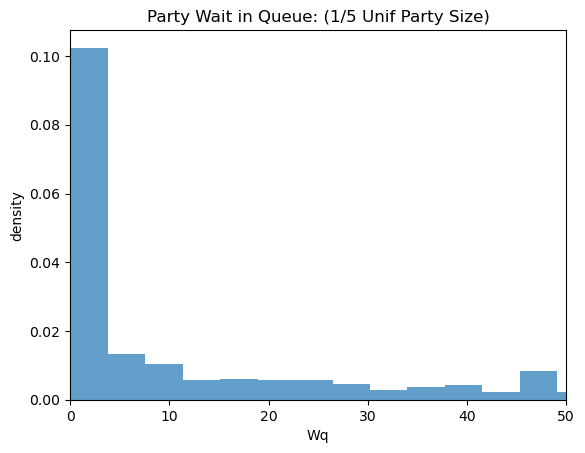

In [29]:
N = 1000

arrivals = rng.uniform(0,5, size=N)
sizes = np.random.randint(1, 6, size=N)

avg_waits,weight,lines,parties = CreatePartyFill(arrivals,sizes)

plt.figure()
plt.hist(avg_waits, bins=100, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Party Wait in Queue: (1/5 Unif Party Size)")
plt.xlim(0, 50)

s = pd.Series(avg_waits)
s.describe()

### Repeated N=1000 Uniform Fill Trials by Individual

Text(0.5, 1.0, 'Mean wait times for N = 1000')

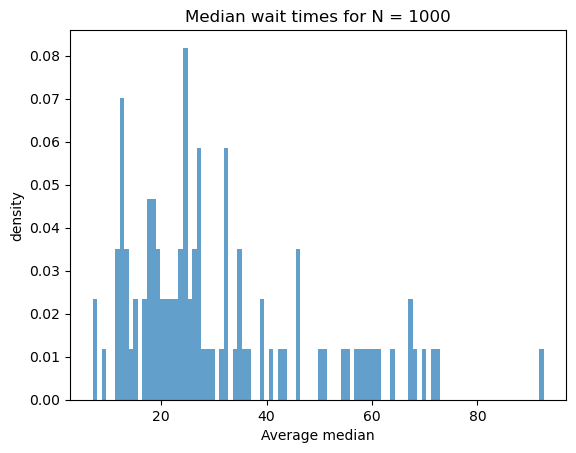

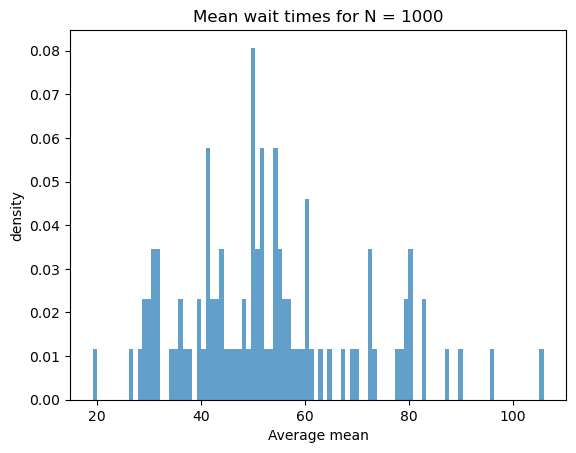

In [30]:
N = 1000
means = []
medians = []

for i in range(100):
    arrivals = rng.uniform(0,5, size=N)
    sizes = np.random.randint(1, 6, size=N)

    avg_waits,weight,dfl,parties = CreatePartyFill(arrivals,sizes)

    s = pd.Series(avg_waits)
    means.append(s.describe()[1])
    medians.append(s.describe()[5])


plt.figure()
plt.hist(medians, bins=100, density=True, alpha=0.7)
plt.xlabel("Average median"); plt.ylabel("density"); plt.title("Median wait times for N = 1000")

plt.figure()
plt.hist(means, bins=100, density=True, alpha=0.7)
plt.xlabel("Average mean"); plt.ylabel("density"); plt.title("Mean wait times for N = 1000")

### Fill Test when N = 1000 Uniform by Individual

count    565.000000
mean     124.501375
std      123.288801
min        0.000000
25%        0.000000
50%      106.674644
75%      203.123727
max      378.046950
dtype: float64

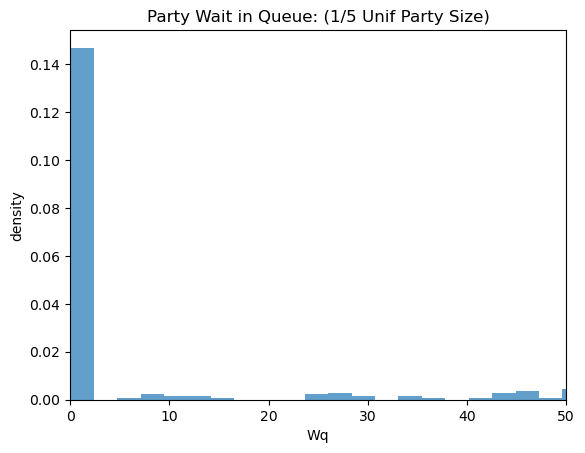

In [45]:
N = 1000

arrivals = rng.uniform(0,5, size=N)
sizes = np.random.randint(1, 6, size=N)

avg_waits,weight,lines,parties = CreatePartyFill(arrivals,sizes)

plt.figure()
plt.hist(avg_waits, bins=100, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Party Wait in Queue: (1/5 Unif Party Size)")
plt.xlim(0, 50)

s = pd.Series(weight)
s.describe()

### Repeated N=1000 Uniform Fill Trials by Individual

Text(0.5, 1.0, 'Mean wait times for N = 1000')

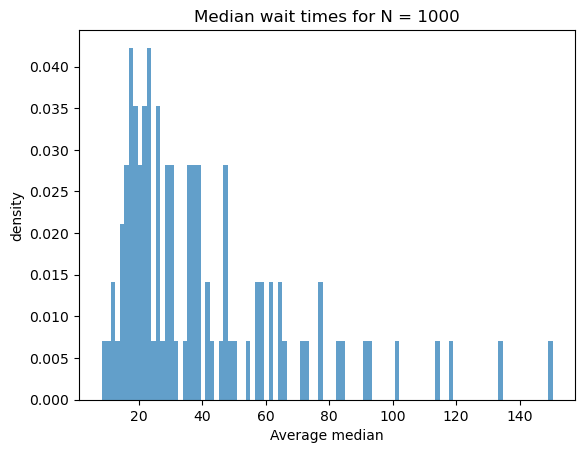

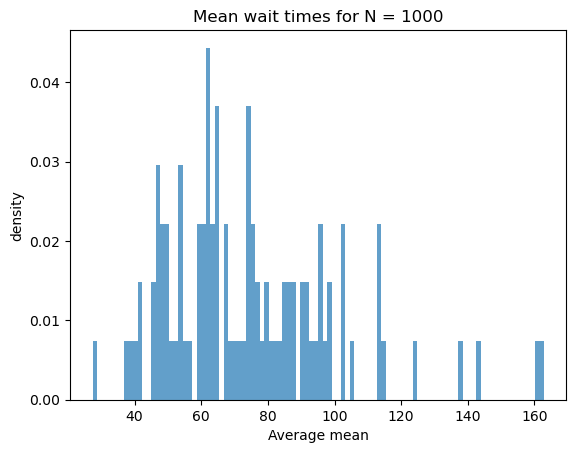

In [46]:
N = 1000
means = []
medians = []

for i in range(100):
    arrivals = rng.uniform(0,5, size=N)
    sizes = np.random.randint(1, 6, size=N)

    avg_waits,weight,lines,parties = CreatePartyFill(arrivals,sizes)

    s = pd.Series(weight)
    means.append(s.describe()[1])
    medians.append(s.describe()[5])


plt.figure()
plt.hist(medians, bins=100, density=True, alpha=0.7)
plt.xlabel("Average median"); plt.ylabel("density"); plt.title("Median wait times for N = 1000")

plt.figure()
plt.hist(means, bins=100, density=True, alpha=0.7)
plt.xlabel("Average mean"); plt.ylabel("density"); plt.title("Mean wait times for N = 1000")